# Transformation Interpolations:  DES DR2 <--> PanSTARRS1 DR2

_Douglas L. Tucker_

_2021.03.17_

## Initial Setup

In [28]:
import numpy as np
import pandas as pd

import os
import sys
import glob
import math
import datetime

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp
import healpixTools

import extinction

import paramFile

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

import matplotlib.pyplot as plt

%matplotlib inline

## Input Parameters

In [31]:
# List of bands on which to run the transform fit...
bandList = ['g', 'r', 'i', 'z', 'Y']
#bandList = ['g']
            
# PS1-->DES (toDES=True) or DES-->PS1 (toDES=False)...
toDES = True
#toDES = False

# Color to fit against...
#color_name_1 = 'gi'
color_name_1 = 'ri'


# Name of color_name_1 as the label in the QA plots...
#colorLabel_1 = '(g-i)'
colorLabel_1 = '(r-i)'


if toDES:
    # If PS1-->DES, then the color to fit against and its plot label are PS1...
    color_name_1 = """%s_ps1""" % (color_name_1)
    colorLabel_1 = """$%s_{ps1}$""" % colorLabel_1    
else:
    # If DES-->PS1, then the color to fit against and its plot label are DES...
    color_name_1 = """%s_des""" % (color_name_1)
    colorLabel_1 = """$%s_{des}$""" % colorLabel_1    


# Size of the binsize in color
color_binsize = 0.10

# Identify directory containing the DES/PS1 match file...
matchDir = '.'

# Name of the DES/PS1 match file in matchDir
matchFile = 'match_y6a2_stripe82area_stars_PS1DR2.fits'

# Base name of fit results output file...
if toDES:
    resultsFileBaseName = 'transInterp.ps1_to_des'
else:
    resultsFileBaseName = 'transInterp.des_to_ps1'

# Base name of QA plot output files...
if toDES:
    qaFileBaseName = 'qaPlot.ps1_to_des.interp'
else:
    qaFileBaseName = 'qaPlot.des_to_ps1.interp'

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2

## Define Some Modules

In [3]:
# From Zeljko Ivezic:
# Robust estimate of standard deviation: 0.741*(q75-q25)
#  sigmaG = 0.741*(np.percentile(yAux,75)-np.percentile(yAux,25))
# Uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(N)
#  sigGbin[i] = np.sqrt(np.pi/2)*sigmaG/np.sqrt(nPts[i])

def robustStdDev(data):
    sd = 0.741*(np.percentile(data,75)-np.percentile(data,25))
    return sd

def uncMedian(data, npts):
    sd = robustStdDev(data)
    uncMedian = np.sqrt(np.pi/2)*sd/np.sqrt(npts)
    return uncMedian

In [4]:
##################################

def interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                         title, dmagLabel, outputFileName, verbose):

        
    # Create linear interpolation of the median dmag vs. color bin calculated above...
    response = interpolate.interp1d(df1.index.values.astype(float), df1.bin_median.values, \
                                bounds_error=False, fill_value=0., kind='linear')    

    # Calculate and apply the offset for the individual stars in df, 
    #  based on the linear interpolation calculated above...
    df['offset'] = response(df[color_name_1].values)    
    df['res'] = df['dmag'] - df['offset']    
    if verbose>1:
        print 
        print df[[color_name_1, 'offset', 'res']].head()
        print 

    # Calculate the 'robust' RMS of the residuals....
    rms = robustStdDev(df['res'].values)


    # Identify range to plot in the dmag (Y-axis) direction...
    dmag_desc = df['dmag'].describe(percentiles=[0.001, 0.999])
    if verbose>1:
        print dmag_desc
    dmag_min = math.floor(10*dmag_desc['0.1%'])/10.
    dmag_max = math.ceil(10*dmag_desc['99.9%'])/10.

    dmag_mask = (df['dmag'] >= dmag_min) & (df['dmag'] <= dmag_max)
    df_dmag_mask = df[dmag_mask]
    

    # Identify range to plot in the residuals (Y-axis) direction...
    res_desc = df['res'].describe(percentiles=[0.01, 0.99])
    if verbose>1:
        print 
        print res_desc
        print 
    #res_min = math.floor(10*dmag_desc['1%'])/10.
    #res_max = math.ceil(10*dmag_desc['99%'])/10.
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    res_min = -0.10
    res_max = +0.10


    # For 2d binning below, we mask df for just those stars within 
    #  the res_min, res_max range...
    res_mask = (df['res'] >= res_min) & (df['res'] <= res_max)
    df_res_mask = df[res_mask]
    
    
    # Prepare QA plots...
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    
    # Modify matplotlib font...
    #font = {'family' : 'normal',
    #        'weight' : 'bold',
    #       'size'   : 22}
    #matplotlib.rc('font', **font)    
    plt.rcParams.update({'font.size': 24})

    
    ## Include a supertitle to the matplotlob figure...
    #fig.suptitle('This is the superTitle')

    
    # Plot 1:  Descriptive text...
    plt.subplot(221)
    plot1Text = """%s \n\n\n\n%s vs. %s\n\n[rms: %.3f] \n\n[%.1f < %s < %.1f]""" % \
                    (title, dmagLabel, colorLabel_1, rms, color1_min, colorLabel_1, color1_max)
    plt.text(0.1,0.00,plot1Text)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    plt.subplot(222)
    hb=plt.hexbin(df_dmag_mask[color_name_1].values, df_dmag_mask['dmag'].values, \
                      gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel(dmagLabel)
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)
    # Overplot the binned values calculated above:
    plt.errorbar(df1.index.values.astype(float), df1.bin_median.values, yerr=df1.bin_unc.values, fmt='o')

    
    # Plot 3:  1d histogram of residuals...
    plt.subplot(223) 
    plt.hist(df_res_mask.loc[:,'res'],bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.xlim([res_min, res_max])
    plt.grid(True)
    plt.grid(color='black')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    plt.subplot(224) 
    hb=plt.hexbin(df_res_mask.loc[:, color_name_1].values, df_res_mask.loc[:,'res'].values, \
                  gridsize=100, bins='log', cmap='inferno')
    ax=plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel_1)
    plt.ylabel('Residuals')
    cb = fig.colorbar(hb)
    #cb.set_label('Number')
    cb.set_label('log10(N)')
    plt.grid(color='white')
    plt.grid(True)
    
    
    # Plot...
    plt.tight_layout()
    

    # Save QA plots to file...
    plt.savefig(outputFileName)    
    

    return 0


##################################

## Read in Matched Catalog

In [5]:
matchFile = os.path.join(matchDir,matchFile)
print matchFile

./match_y6a2_stripe82area_stars_PS1DR2.fits


In [6]:
# Check to make sure matchFile exists...
if os.path.isfile(matchFile)==False:
    print """ERROR:  matchFile %s does not exist...""" % (matchFile)
if verbose > 0:
    print 'matchFile: ', matchFile


matchFile:  ./match_y6a2_stripe82area_stars_PS1DR2.fits


In [7]:
tab = Table.read(matchFile, format='fits')
tab

COADD_OBJECT_ID,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,B,EBV_SFD98,HPIX_32,HPIX_64,HPIX_1024,HPIX_4096,HPIX_16384,KRON_RADIUS,A_IMAGE,B_IMAGE,THETA_J2000,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,XWIN_IMAGE,YWIN_IMAGE,MAG_DETMODEL_G,MAG_AUTO_G,MAG_APER_8_G,WAVG_MAG_PSF_G,MAGERR_DETMODEL_G,MAGERR_AUTO_G,MAGERR_APER_8_G,WAVG_MAGERR_PSF_G,FLUX_DETMODEL_G,FLUX_AUTO_G,WAVG_FLUX_PSF_G,FLUX_RADIUS_G,FLUX_APER_8_G,FLUXERR_DETMODEL_G,FLUXERR_AUTO_G,WAVG_FLUXERR_PSF_G,FLUXERR_APER_8_G,MU_EFF_MODEL_G,MU_MAX_G,MU_MAX_MODEL_G,MU_MEAN_MODEL_G,MU_THRESHOLD_G,SPREADERR_MODEL_G,SPREAD_MODEL_G,CLASS_STAR_G,NITER_MODEL_G,WAVG_SPREADERR_MODEL_G,WAVG_SPREAD_MODEL_G,FLAGS_G,IMAFLAGS_ISO_G,NEPOCHS_G,MOLY_NUMBER_G,MAG_DETMODEL_R,MAG_AUTO_R,MAG_APER_8_R,WAVG_MAG_PSF_R,MAGERR_DETMODEL_R,MAGERR_AUTO_R,MAGERR_APER_8_R,WAVG_MAGERR_PSF_R,FLUX_DETMODEL_R,FLUX_AUTO_R,WAVG_FLUX_PSF_R,FLUX_RADIUS_R,FLUX_APER_8_R,FLUXERR_DETMODEL_R,FLUXERR_AUTO_R,WAVG_FLUXERR_PSF_R,FLUXERR_APER_8_R,MU_EFF_MODEL_R,MU_MAX_R,MU_MAX_MODEL_R,MU_MEAN_MODEL_R,MU_THRESHOLD_R,SPREADERR_MODEL_R,SPREAD_MODEL_R,CLASS_STAR_R,NITER_MODEL_R,WAVG_SPREADERR_MODEL_R,WAVG_SPREAD_MODEL_R,FLAGS_R,IMAFLAGS_ISO_R,NEPOCHS_R,MOLY_NUMBER_R,MAG_DETMODEL_I,MAG_AUTO_I,MAG_APER_8_I,WAVG_MAG_PSF_I,MAGERR_DETMODEL_I,MAGERR_AUTO_I,MAGERR_APER_8_I,WAVG_MAGERR_PSF_I,FLUX_DETMODEL_I,FLUX_AUTO_I,WAVG_FLUX_PSF_I,FLUX_RADIUS_I,FLUX_APER_8_I,FLUXERR_DETMODEL_I,FLUXERR_AUTO_I,WAVG_FLUXERR_PSF_I,FLUXERR_APER_8_I,MU_EFF_MODEL_I,MU_MAX_I,MU_MAX_MODEL_I,MU_MEAN_MODEL_I,MU_THRESHOLD_I,SPREADERR_MODEL_I,SPREAD_MODEL_I,CLASS_STAR_I,NITER_MODEL_I,WAVG_SPREADERR_MODEL_I,WAVG_SPREAD_MODEL_I,FLAGS_I,IMAFLAGS_ISO_I,NEPOCHS_I,MOLY_NUMBER_I,MAG_DETMODEL_Z,MAG_AUTO_Z,MAG_APER_8_Z,WAVG_MAG_PSF_Z,MAGERR_DETMODEL_Z,MAGERR_AUTO_Z,MAGERR_APER_8_Z,WAVG_MAGERR_PSF_Z,FLUX_DETMODEL_Z,FLUX_AUTO_Z,WAVG_FLUX_PSF_Z,FLUX_RADIUS_Z,FLUX_APER_8_Z,FLUXERR_DETMODEL_Z,FLUXERR_AUTO_Z,WAVG_FLUXERR_PSF_Z,FLUXERR_APER_8_Z,MU_EFF_MODEL_Z,MU_MAX_Z,MU_MAX_MODEL_Z,MU_MEAN_MODEL_Z,MU_THRESHOLD_Z,SPREADERR_MODEL_Z,SPREAD_MODEL_Z,CLASS_STAR_Z,NITER_MODEL_Z,WAVG_SPREADERR_MODEL_Z,WAVG_SPREAD_MODEL_Z,FLAGS_Z,IMAFLAGS_ISO_Z,NEPOCHS_Z,MOLY_NUMBER_Z,MAG_DETMODEL_Y,MAG_AUTO_Y,MAG_APER_8_Y,WAVG_MAG_PSF_Y,MAGERR_DETMODEL_Y,MAGERR_AUTO_Y,MAGERR_APER_8_Y,WAVG_MAGERR_PSF_Y,FLUX_DETMODEL_Y,FLUX_AUTO_Y,WAVG_FLUX_PSF_Y,FLUX_RADIUS_Y,FLUX_APER_8_Y,FLUXERR_DETMODEL_Y,FLUXERR_AUTO_Y,WAVG_FLUXERR_PSF_Y,FLUXERR_APER_8_Y,MU_EFF_MODEL_Y,MU_MAX_Y,MU_MAX_MODEL_Y,MU_MEAN_MODEL_Y,MU_THRESHOLD_Y,SPREADERR_MODEL_Y,SPREAD_MODEL_Y,CLASS_STAR_Y,NITER_MODEL_Y,WAVG_SPREADERR_MODEL_Y,WAVG_SPREAD_MODEL_Y,FLAGS_Y,IMAFLAGS_ISO_Y,NEPOCHS_Y,MOLY_NUMBER_Y,objName,raMean,decMean,raMeanErr,decMeanErr,qualityFlag,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagNpt,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagNpt,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagNpt,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagNpt,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagNpt,rMeanKronMag,rMeanKronMagErr,nDetections,ng,nr,ni,nz,ny,gFlags,gQfPerfect,rFlags,rQfPerfect,iFlags,iQfPerfect,zFlags,zQfPerfect,yFlags,yQfPerfect,primaryDetection,bestDetection,Separation
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec
int64,float64,float64,float64,float64,int64,int32,int32,str48,float64,float64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,int16,int32,int32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int

In [8]:
df = tab.to_pandas()
df

,COADD_OBJECT_ID,RA,DEC,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,...,rQfPerfect,iFlags,iQfPerfect,zFlags,zQfPerfect,yFlags,yQfPerfect,primaryDetection,bestDetection,Separation
0,1.032381e+09,0.000040,-2.920423,0.000040,-2.920423,2764753.0,24171.0,26079.0,DES0000-0250,93.788193,...,0.999859,115000.0,0.999350,115000.0,0.998937,115000.0,0.998969,1.0,1.0,0.041387
1,1.033365e+09,0.000056,1.844355,0.000056,1.844355,2763744.0,5582.0,5774.0,DES0000+0209,97.743225,...,0.999215,115064.0,0.999670,115064.0,0.998535,115064.0,0.998158,1.0,1.0,0.006762
2,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,0.999743,115000.0,0.999144,115000.0,0.999616,115000.0,0.998564,1.0,1.0,0.015032
3,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,0.999726,115000.0,0.999183,115000.0,0.999046,115000.0,0.999625,1.0,1.0,0.013966
4,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,0.999684,115064.0,0.999666,115064.0,0.999672,115064.0,0.999565,1.0,1.0,0.008995
5,1.033057e+09,0.000144,2.314278,0.000144,2.314278,2763744.0,53774.0,57644.0,DES0000+0209,98.079956,...,0.999658,115000.0,0.999516,115000.0,0.999613,115000.0,0.999699,1.0,1.0,0.001272
6,1.032720e+09,0.000241,0.077140,0.000241,0.077140,2758896.0,39829.0,43741.0,DES2359+0001,96.399406,...,0.999532,115064.0,0.999217,115064.0,0.999708,115064.0,0.999606,1.0,1.0,0.009884
7,1.034107e+09,0.000249,-0.838739,0.000249,-0.838739,2764748.0,20138.0,22019.0,DES2359-0041,95.649406,...,0.999684,115000.0,0.999278,115000.0,0.999047,115000.0,0.999208,1.0,1.0,0.019629
8,1.034254e+09,0.000297,-1.034322,0.000297,-1.034322,2764748.0,3080.0,2902.0,DES2359-0041,95.484200,...,0.999709,115000.0,0.999076,115000.0,0.998940,115000.0,0.998931,1.0,1.0,0.009879
9,1.033052e+09,0.000603,2.368938,0.000603,2.368938,2763744.0,59148.0,63542.0,DES0000+0209,98.119377,...,0.999539,115000.0,0.999688,115000.0,0.999775,115000.0,0.999464,1.0,1.0,0.010729


In [9]:
# Rename columns...
df.rename(columns={'RA':'RA_des',
                   'DEC':'DEC_des',
                   'raMean':'RA_ps1',
                   'decMean':'DEC_ps1',
                   'WAVG_MAG_PSF_G':'g_des',
                   'WAVG_MAG_PSF_R':'r_des',
                   'WAVG_MAG_PSF_I':'i_des',
                   'WAVG_MAG_PSF_Z':'z_des',
                   'WAVG_MAG_PSF_Y':'Y_des',
                   'WAVG_MAGERR_PSF_G':'g_err_des',
                   'WAVG_MAGERR_PSF_R':'r_err_des',
                   'WAVG_MAGERR_PSF_I':'i_err_des',
                   'WAVG_MAGERR_PSF_Z':'z_err_des',
                   'WAVG_MAGERR_PSF_Y':'Y_err_des',
                   'gMeanPSFMag':'g_ps1',
                   'rMeanPSFMag':'r_ps1',
                   'iMeanPSFMag':'i_ps1',
                   'zMeanPSFMag':'z_ps1',
                   'yMeanPSFMag':'Y_ps1',
                   'gMeanPSFMagErr':'g_err_ps1',
                   'rMeanPSFMagErr':'r_err_ps1',
                   'iMeanPSFMagErr':'i_err_ps1',
                   'zMeanPSFMagErr':'z_err_ps1',
                   'yMeanPSFMagErr':'Y_err_ps1',
                  },inplace=True)

df.head(5)

,COADD_OBJECT_ID,RA_des,DEC_des,ALPHAWIN_J2000,DELTAWIN_J2000,PFW_ATTEMPT_ID,OBJECT_NUMBER,PARENT_NUMBER,TILENAME,L,...,rQfPerfect,iFlags,iQfPerfect,zFlags,zQfPerfect,yFlags,yQfPerfect,primaryDetection,bestDetection,Separation
0,1.032381e+09,0.000040,-2.920423,0.000040,-2.920423,2764753.0,24171.0,26079.0,DES0000-0250,93.788193,...,0.999859,115000.0,0.999350,115000.0,0.998937,115000.0,0.998969,1.0,1.0,0.041387
1,1.033365e+09,0.000056,1.844355,0.000056,1.844355,2763744.0,5582.0,5774.0,DES0000+0209,97.743225,...,0.999215,115064.0,0.999670,115064.0,0.998535,115064.0,0.998158,1.0,1.0,0.006762
2,1.033597e+09,0.000058,-2.417387,0.000058,-2.417387,2758897.0,7033.0,7252.0,DES0000-0207,94.259300,...,0.999743,115000.0,0.999144,115000.0,0.999616,115000.0,0.998564,1.0,1.0,0.015032
3,1.032384e+09,0.000101,-2.967177,0.000101,-2.967177,2764753.0,20554.0,22091.0,DES0000-0250,93.743797,...,0.999726,115000.0,0.999183,115000.0,0.999046,115000.0,0.999625,1.0,1.0,0.013966
4,1.032146e+09,0.000110,3.352002,0.000110,3.352002,2763748.0,10494.0,11267.0,DES0000+0335,98.794853,...,0.999684,115064.0,0.999666,115064.0,0.999672,115064.0,0.999565,1.0,1.0,0.008995


## Add Columns to Matched Catalog Data Frame

In [10]:
# Add color columns...
df.loc[:,'gr_des'] = df.loc[:,'g_des'] - df.loc[:,'r_des']
df.loc[:,'ri_des'] = df.loc[:,'r_des'] - df.loc[:,'i_des']
df.loc[:,'iz_des'] = df.loc[:,'i_des'] - df.loc[:,'z_des']
df.loc[:,'zY_des'] = df.loc[:,'z_des'] - df.loc[:,'Y_des']
df.loc[:,'gi_des'] = df.loc[:,'g_des'] - df.loc[:,'i_des']

df.loc[:,'gr_ps1'] = df.loc[:,'g_ps1'] - df.loc[:,'r_ps1']
df.loc[:,'ri_ps1'] = df.loc[:,'r_ps1'] - df.loc[:,'i_ps1']
df.loc[:,'iz_ps1'] = df.loc[:,'i_ps1'] - df.loc[:,'z_ps1']
df.loc[:,'zY_ps1'] = df.loc[:,'z_ps1'] - df.loc[:,'Y_ps1']
df.loc[:,'gi_ps1'] = df.loc[:,'g_ps1'] - df.loc[:,'i_ps1']

In [11]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

## Create Initial Mask

In [32]:
mask = ( ( df[color_name_1] > -1. ) & ( df[color_name_1] < 4.0 ) )

## Make Backup Copies of Initial Mask and Original Data Frame

In [33]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

## Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
g
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count     474216.000000
mean           0.493358
std            0.373338
min           -0.480101
0.01%         -0.330630
50%            0.344099
99.99%         2.008029
max            2.210899
Name: ri_ps1, dtype: float64
-0.4 2.1

[ -4.00000000e-01  -3.00000000e-01  -2.00000000e-01  -1.00000000e-01
  -1.11022302e-16   1.00000000e-01   2.00000000e-01   3.00000000e-01
   4.00000000e-01   5.00000000e-01   6.00000000e-01   7.00000000e-01
   8.00000000e-01   9.00000000e-01   1.00000000e+00   1.10000000e+00
   1.20000000e+00   1.30000000e+00   1.40000000e+00   1.50000000e+00
   1.60000000e+00   1.70000000e+00   1.80000000e+00   1.90000000e+00
   2.00000000e+00   2.10000000e+00]
[-0.35 -0.25 -0.15 -0.05  0.05  0.15  0.25  0.35  0.45  0.55  0.65  0.75
  0.85  0.95  1.05  1.15  1.25  1.35  1.45  1.55  1.65  1.75  1.85  1.95
  2.05]

   


count    472743.000000
mean         -0.000087
std           0.010666
min          -0.620617
1%           -0.024630
50%          -0.000051
99%           0.023458
max           0.418429
Name: res, dtype: float64




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
i
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count     473975.000000
mean           0.493407
std            0.373320
min           -0.435701
0.01%         -0.329180
50%            0.344099
99.99%         2.008085
max            2.210899
Name: ri_ps1, dtype: float64
-0.4 2.1

[ -4.00000000e-01  -3.00000000e-01  -2.00000000e-01  -1.00000000e-01
  -1.11022302e-16   1.00000000e-01   2.00000000e-01   3.00000000e-01
   4.00000000e-01   5.00000000e-01   6.00000000e-01   7.00000000e-01
   8.00000000e-01   9.00000000e-01   1.00000000e+00   1.10000000e+00
   1.20000000e+00   1.30000000e+00   1.40000000e+00   1.50000000e+00
   1.60000000e+00   1.70000000e+00   1.80000000e+00


count    471770.000000
mean         -0.000131
std           0.011597
min          -0.665323
1%           -0.025957
50%           0.000019
99%           0.024855
max           0.547264
Name: res, dtype: float64




# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
Y
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


count     474216.000000
mean           0.493358
std            0.373338
min           -0.480101
0.01%         -0.330630
50%            0.344099
99.99%         2.008029
max            2.210899
Name: ri_ps1, dtype: float64
-0.4 2.1

[ -4.00000000e-01  -3.00000000e-01  -2.00000000e-01  -1.00000000e-01
  -1.11022302e-16   1.00000000e-01   2.00000000e-01   3.00000000e-01
   4.00000000e-01   5.00000000e-01   6.00000000e-01   7.00000000e-01
   8.00000000e-01   9.00000000e-01   1.00000000e+00   1.10000000e+00
   1.20000000e+00   1.30000000e+00   1.40000000e+00   1.50000000e+00
   1.60000000e+00   1.70000000e+00   1.80000000e+00

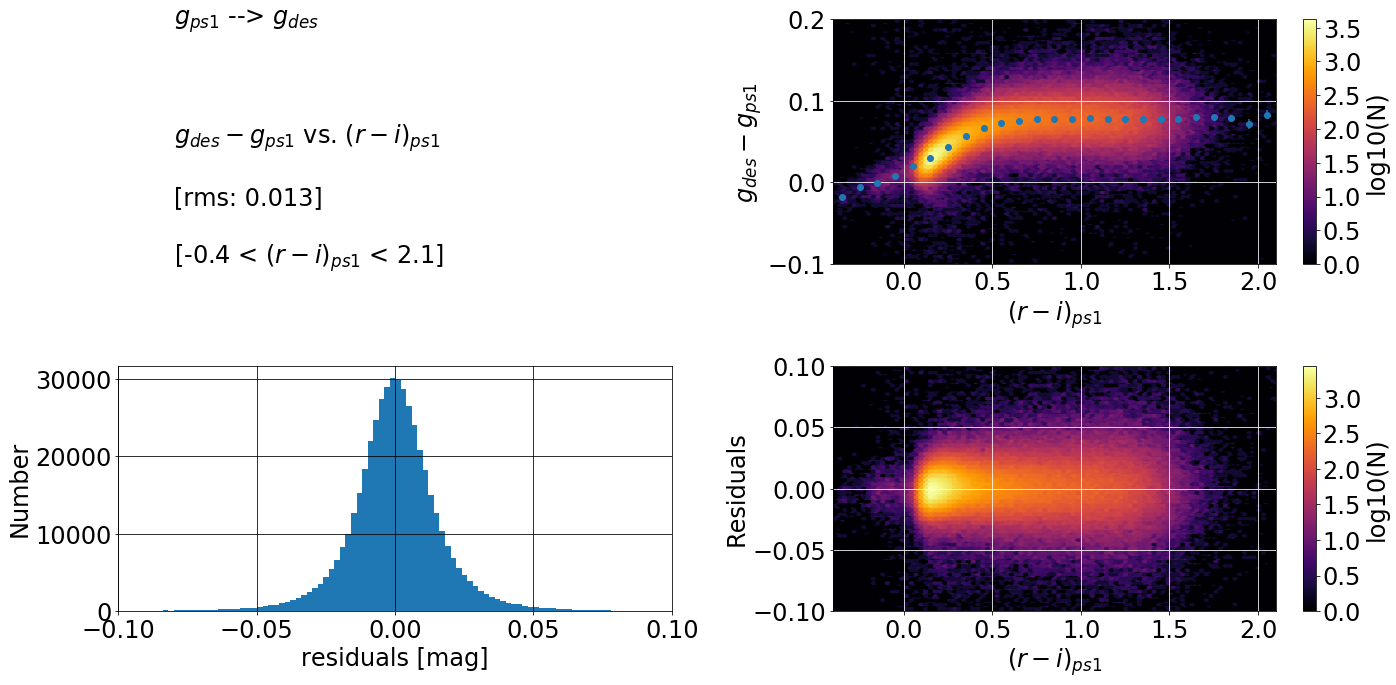

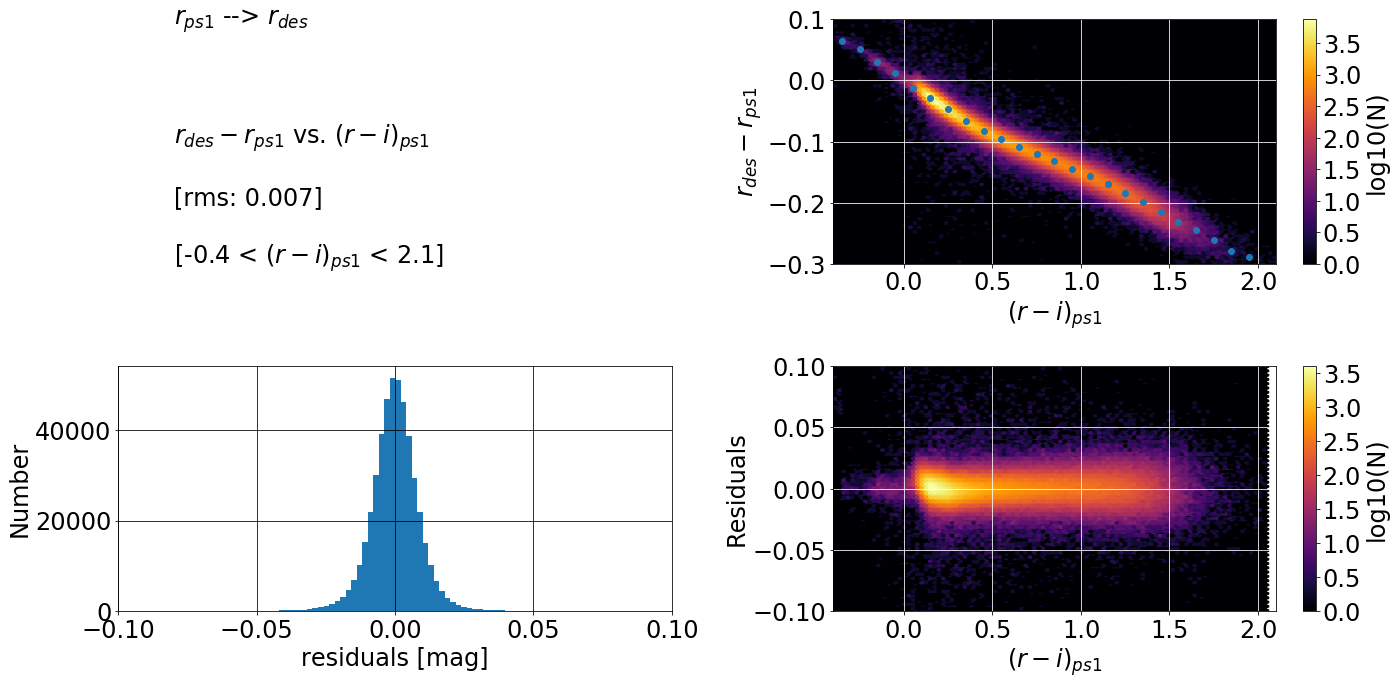

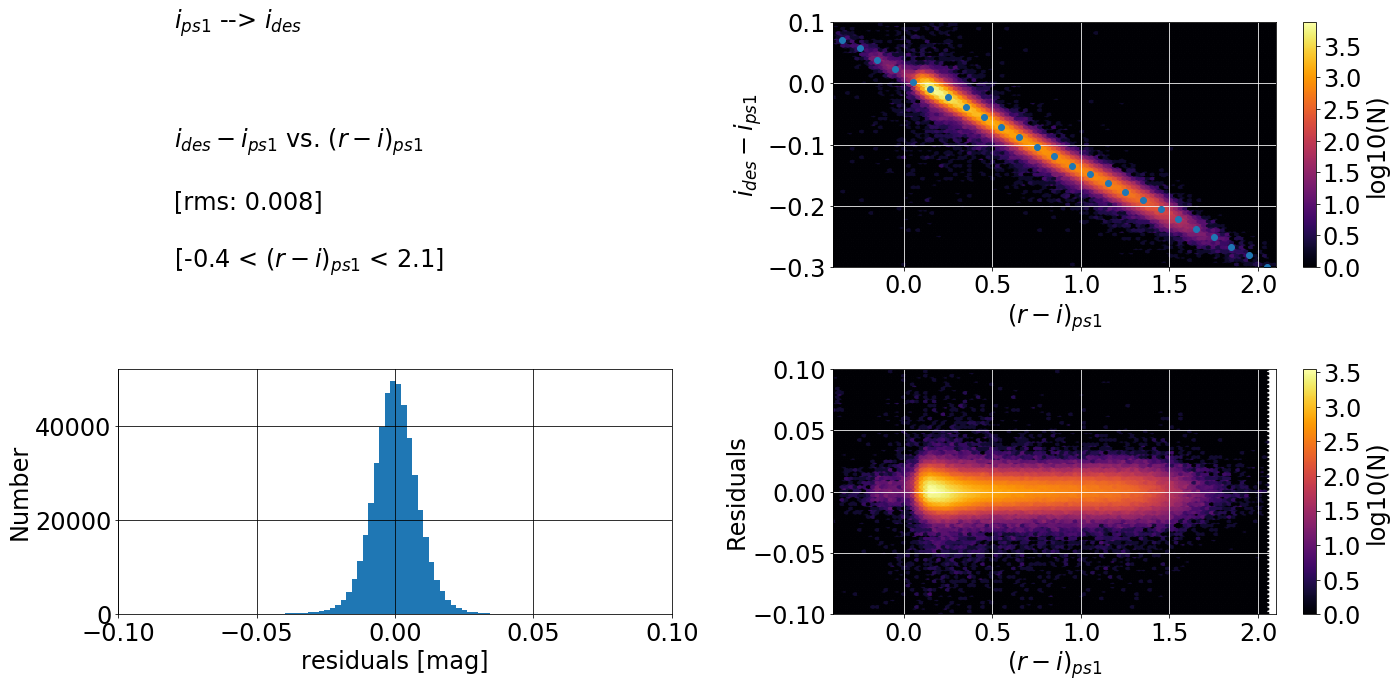

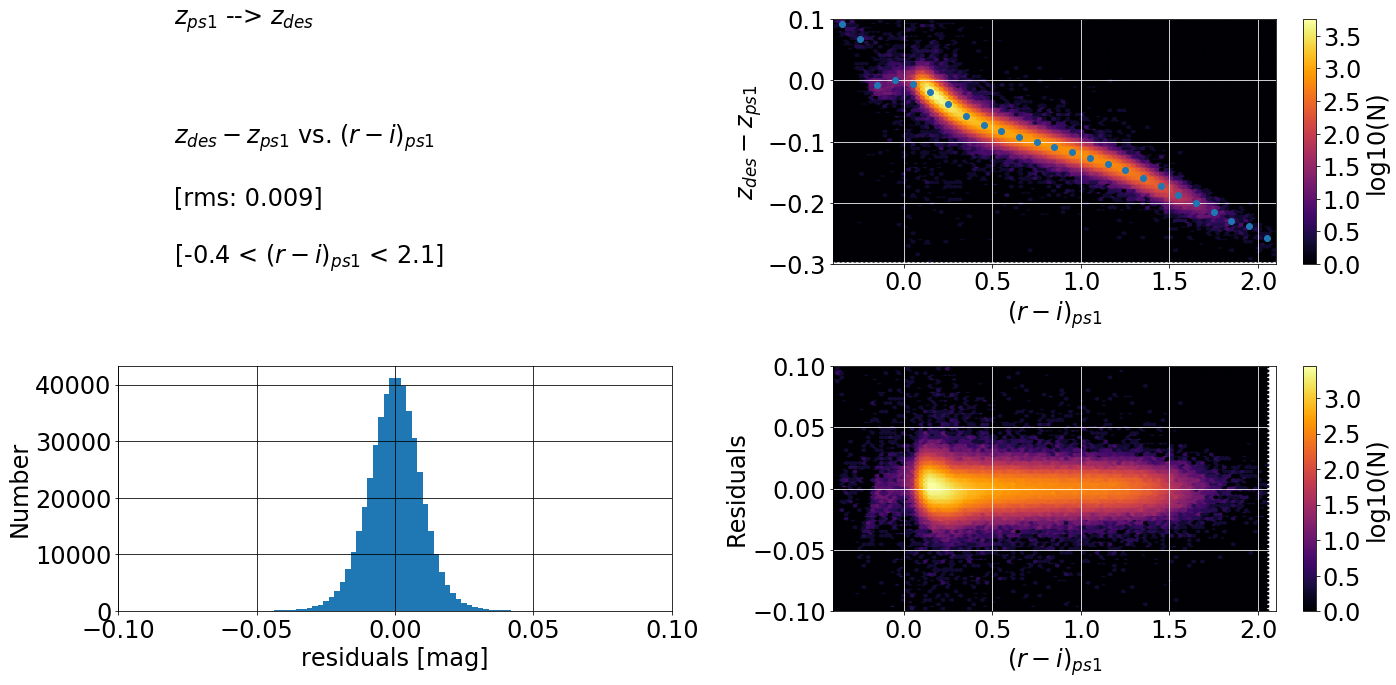

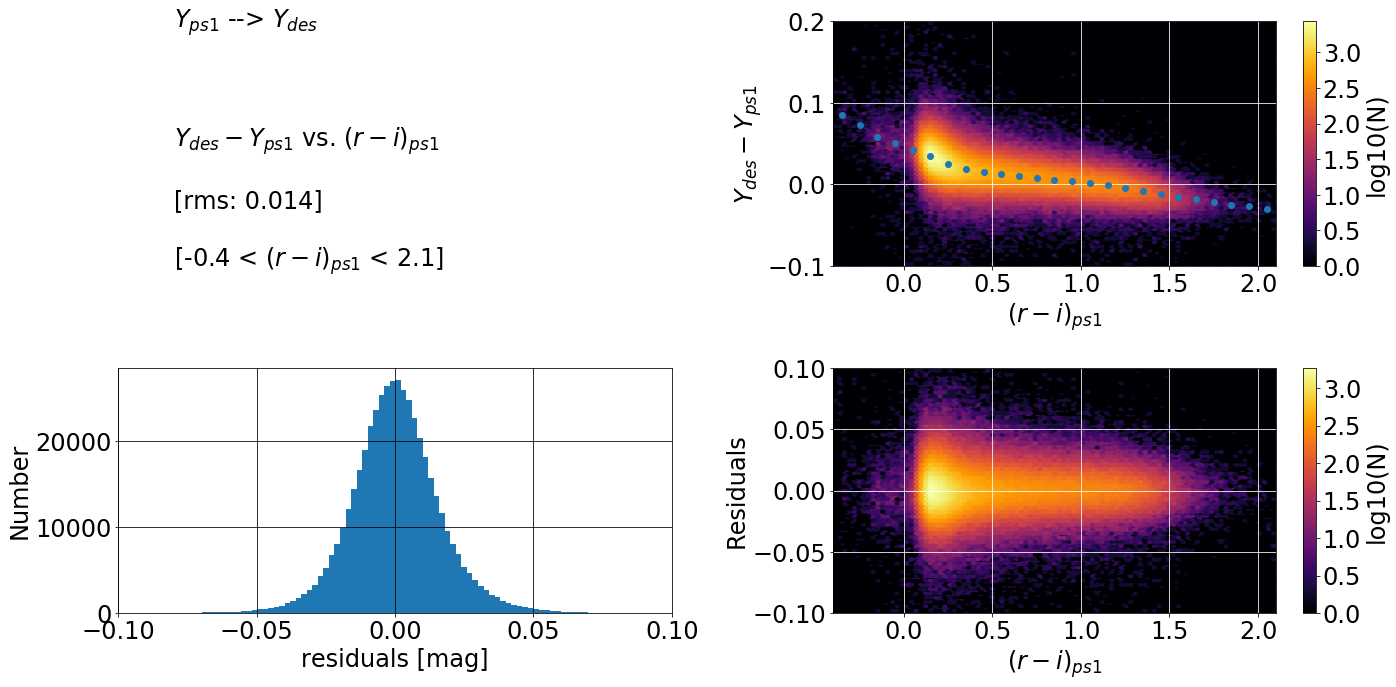

In [34]:
for band in bandList:
    
    print 
    print 
    print 
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print band
    print "# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # "
    print 
    
    magName_des = """%s_des""" % (band)
    magErrName_des = """%s_err_des""" % (band)
    magName_ps1 = """%s_ps1""" % (band)
    magErrName_ps1 = """%s_err_ps1""" % (band)
    
    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band}_des - {$band}_ps1...
    if toDES:
        df.loc[:,'dmag'] = df.loc[:,magName_des] - df.loc[:,magName_ps1]
    else:
        df.loc[:,'dmag'] = df.loc[:,magName_ps1] - df.loc[:,magName_des]

    # Update mask...
    mask1 = abs(df['dmag']) <= 10.
    mask2 = abs(df[magErrName_des]) <= 0.01
    mask3 = abs(df[magErrName_ps1]) <= 0.02
    mask = mask & mask1 & mask2 & mask3

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Identify dmag and color1 series...
    dmag =  df.loc[:,'dmag']
    color1 = df.loc[:,color_name_1]


    # Calculate the color range to bin and the number of bins, 
    #  based on the 0.01%-99.99% color range...
    color1_desc = df[color_name_1].describe(percentiles=[0.0001, 0.9999])
    color1_min = math.floor(10*color1_desc['0.01%'])/10.
    color1_max = math.ceil(10*color1_desc['99.99%'])/10.
    if verbose>1:
        print 
        print color1_desc
        print color1_min, color1_max 
        print 
    binsize = color_binsize
    ranges = np.arange(color1_min,color1_max+binsize,binsize)
    # Label the bins by their mid-point...
    labels = np.arange(color1_min,color1_max,binsize) + 0.5*binsize
    
    #nbins = int((color1_max-color1_min)/binsize)+1
    #ranges = np.linspace(color1_min, color1_max, nbins+1)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins) + 0.5*binsize

    #nbins = math.floor((color1_max-color1_min)/binsize) + 1
    #ranges = np.linspace(color1_min, color1_max, nbins)
    ## Label the bins by their mid-point...
    #labels = np.linspace(color1_min, color1_max-binsize, nbins-1) + 0.5*binsize
    
    if verbose:
        print ranges
        print labels
    
    # Bin the data, adding "bin_interval" and "bin_label' to the df dataframe...
    df['bin_interval'] = pd.cut(df[color_name_1], bins=ranges, precision=0)
    df['bin_label'] = pd.cut(df[color_name_1], bins=ranges, labels=labels)
    if verbose>1:
        print 
        print df[[color_name_1,'bin_interval','bin_label']].head()
        print 

    # Perform pandas grouping/aggregating functions on sigma-clipped Data Frame...
    df_grp = df.groupby(['bin_label'])
    bin_interval = df_grp['bin_interval'].first()
    dmag_num = df_grp['dmag'].count()
    dmag_mean = df_grp['dmag'].mean()
    dmag_sd = df_grp['dmag'].std()
    dmag_err = dmag_sd/np.sqrt(dmag_num-1)
    dmag_median = df_grp['dmag'].median()
    dmag_rsd = df_grp['dmag'].apply(robustStdDev)
    dmag_unc = np.sqrt(np.pi/2)*dmag_rsd/np.sqrt(dmag_num)

    # Rename some of the pandas series...
    dmag_num.name    = 'bin_num'
    dmag_mean.name   = 'bin_mean'
    dmag_sd.name     = 'bin_stddev'
    dmag_err.name    = 'bin_stderr'
    dmag_median.name = 'bin_median'
    dmag_rsd.name    = 'bin_rstddev'
    dmag_unc.name    = 'bin_unc'
    
    # Create new data frame containing all the relevant aggregate quantities...
    df1 = pd.concat( [bin_interval, dmag_num, \
                      dmag_mean, dmag_sd, dmag_err, \
                      dmag_median, dmag_rsd, dmag_unc, ], \
                    join='outer', axis=1 )
    
    if verbose>1:
        print 
        print df1
        print 
    
    
    # Create results output file...
    resultsFile = """%s.%s_%s.csv""" % (resultsFileBaseName, band, color_name_1)
    df1.to_csv(resultsFile)
    if verbose>1:
        print """Writing binned values to %s""" % (resultsFile)

    
    # Create name for QA plot output file...
    outputFileName = """qaPlot_%s.%s_%s.png""" % (resultsFileBaseName, band, color_name_1)

    # Create title and labels for use in QA plots...
    if toDES:
        title = """$%s_{ps1}$ --> $%s_{des}$""" % (band, band)
        dmagLabel = """$%s_{des} - %s_{ps1}$""" % (band, band)
    else:
        title = """$%s_{des}$ --> $%s_{ps1}$""" % (band, band)
        dmagLabel = """$%s_{ps1} - %s_{des}$""" % (band, band)

    # Create QA plots...
    status = interp1ColorQAPlots1(df, df1, color_name_1, color1_min, color1_max, 
                                     title, dmagLabel, outputFileName, verbose)
    
    